In [1]:
import tensorflow as tf
import numpy as np
import os
import sys

slim = tf.contrib.slim

from nets import ssd_vgg_300, np_methods

In [2]:
# Input placeholder.
net_shape = (299, 299)
data_format = 'NHWC'
inputs = tf.placeholder(tf.float32, (None, 299, 299, 3), "input")
# Evaluation pre-processing: resize to SSD net shape.

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(inputs, is_training=False, reuse=reuse)

# Restore SSD model.
ckpt_filename = 'checkpoints/ssd_300_vgg.ckpt/ssd_300_vgg.ckpt'

isess = tf.Session();

isess.run(tf.global_variables_initializer())
saver = tf.train.import_meta_graph('checkpoints/ssd_300_vgg.ckpt/ssd_300_vgg.ckpt.index')
saver.restore(isess, ckpt_filename)

ssd_anchors = ssd_net.anchors(net_shape)
print("restored")

restored


w and heights are always the same for our standard shape
[
[[ 0.07023411  0.10281222  0.04966302  0.09932604],
 [ 0.07023411  0.10281222  0.09932604  0.04966302]],
[[ 0.15050167  0.22323005  0.10642076  0.21284151  0.08689218  0.26067653],
 [ 0.15050167  0.22323005  0.21284151  0.10642076  0.26067653  0.08689218]],
[[ 0.33110368  0.41161588  0.23412566  0.46825132  0.19116279  0.57348841],
 [ 0.33110368  0.41161588  0.46825132  0.23412566  0.57348841  0.19116279]],
[[ 0.5117057   0.59519559  0.36183056  0.72366112  0.2954334   0.88630027],
 [ 0.5117057   0.59519559  0.72366112  0.36183056  0.88630027  0.2954334]],
[[ 0.69230771  0.77738154  0.48953545  0.9790709],
 [ 0.69230771  0.77738154  0.9790709   0.48953545]],
[[ 0.87290972  0.95896852  0.61724037  1.23448074],
 [ 0.87290972  0.95896852  1.23448074  0.61724037]]
]

In [3]:
"""we are passed x,y points and a selection of widths and heights
"""
with tf.variable_scope('select'):
    l_feed = tf.placeholder(tf.float32, [None, None, None, None, None], name="localizations")
    p_feed = tf.placeholder(tf.float32, [None, None, None, None, None], name="predictions")
    
    d_pred = p_feed[:, :, :, :, 1:]
    d_conditions = tf.greater(d_pred, 0.5)
    d_chosen = tf.where(condition=d_conditions)
    c_index = d_chosen[:,:-1]
    
    x_feed = tf.placeholder(tf.float32, [None, None, None], name="x")
    y_feed = tf.placeholder(tf.float32, [None, None, None], name="y")
    
    h_feed = tf.placeholder(tf.float32, [None], name="h")
    w_feed = tf.placeholder(tf.float32, [None], name="w")
    
    box_shape = tf.shape(l_feed)
    box_reshape = [-1, box_shape[-2], box_shape[-1]]
    box_feat_localizations = tf.reshape(l_feed, box_reshape)
    
    box_yref = tf.reshape(y_feed, [-1, 1])
    box_xref = tf.reshape(x_feed, [-1, 1])
    
    box_cx = box_feat_localizations[:, :, 0] * w_feed * 0.1 + box_xref
    box_cy = box_feat_localizations[:, :, 1] * h_feed * 0.1 + box_yref
    box_w = w_feed * tf.exp(box_feat_localizations[:, :, 2] * 0.2)
    box_h = h_feed * tf.exp(box_feat_localizations[:, :, 3] * 0.2)

    box_ymin = box_cy - box_h / 2.
    box_xmin = box_cx - box_w / 2.
    box_xmax = box_cy + box_h / 2.
    box_ymax = box_cx + box_w / 2.

    box_stack = tf.stack([box_ymin, box_xmin, box_xmax, box_ymax], axis=1)
    
    box_transpose = tf.transpose(box_stack, [0,2,1])
    
    box_gather_reshape = tf.reshape(box_transpose, box_shape)
    
    classes_selected = tf.cast(tf.transpose(d_chosen)[-1]+1, tf.float32)
    classes_expand = tf.expand_dims(classes_selected, 1)
    
    box_gather = tf.gather_nd(box_gather_reshape, c_index)
    p_gather = tf.expand_dims(tf.gather_nd(d_pred, d_chosen), 1)
    
    s_out = tf.concat([box_gather, p_gather, classes_expand], axis=1, name="output")

In [4]:
def ssd_bboxes_select_layer(predictions_layer,
                            localizations_layer,
                            anchors_layer,
                            img_shape,
                            select_threshold=0.5):
    
    box_feed = {l_feed: localizations_layer, p_feed: predictions_layer, \
                y_feed: anchors_layer[0], x_feed: anchors_layer[1], \
                h_feed: anchors_layer[2], w_feed: anchors_layer[3]}
    
    output = isess.run([s_out], feed_dict=box_feed)
    
    return output[0]

In [5]:
image_path = os.path.join('images/', 'street_smaller.jpg')

mean = tf.constant([123, 117, 104], dtype=tf.float32)

with tf.variable_scope('image'):
    image_data = tf.gfile.FastGFile(image_path, 'rb').read()
    #we want to use decode_image here but it's buggy
    decoded = tf.image.decode_jpeg(image_data, channels=None)
    normed = tf.divide(tf.cast(decoded, tf.float32), 255.0)
    batched = tf.expand_dims(normed, 0)
    resized_image = tf.image.resize_bilinear(batched, [299, 299])
    standard_size = resized_image
    graph_norm = standard_size * 255.0 - mean
    
with tf.Session() as sess:
    raw_image, file_image, plot_image = sess.run((decoded, graph_norm, standard_size), feed_dict={})

In [6]:
# Main image processing routine.
bbox_img = tf.constant([[0., 0., 1., 1.]])

predictions_net, localizations_net, rbbox_img = isess.run([predictions, localisations, bbox_img],
                                                              feed_dict={'input:0': file_image})

l_bboxes = []

for i in range(6):
    bboxes = ssd_bboxes_select_layer(
        predictions_net[i], localizations_net[i], ssd_anchors[i], img_shape=net_shape)

    l_bboxes.append(bboxes)

bboxes = np.concatenate(l_bboxes, 0)
   
#     implement these 
#     rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
#     rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)


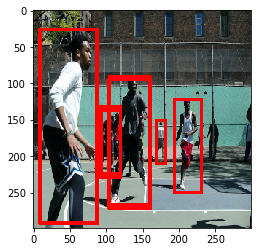

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

fig, ax = plt.subplots(1)
show_image = np.reshape(plot_image, (299,299,3))
ax.imshow(show_image)

for box in bboxes:
    # Create a Rectangle patch
    x = box[1] * 299
    y = box[0] * 299
    w = (box[3]-box[1])*299
    h = (box[2]-box[0])*299
    
    rect = patches.Rectangle((x,y),w,h,linewidth=3,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()